In [1]:
import sys
sys.path.append('/fsx/matzeni/duck')

In [3]:
import torch
import h5py
import json
from pathlib import Path
import pickle
from tqdm import tqdm
import logging
from transformers import AutoTokenizer
from typing import Any, Dict, List, Optional, Tuple
import copy
from einops import rearrange, repeat
import numpy as np
from duck.box_tensors import BoxTensor
from duck.box_tensors.volume import Volume
from duck.box_tensors.intersection import Intersection
from duck.task.duck_entity_disambiguation import Duck
from duck.task import RelToBox
from hydra import compose, initialize
import hydra
from duck.common.utils import seed_prg
import collections
import logging
import math
from omegaconf import open_dict
logger = logging.getLogger()
from torchmetrics import PearsonCorrCoef
import matplotlib.pyplot as plt
import seaborn as sns
import torchmetrics
from matplotlib.colors import LogNorm
from pprint import pprint
import pandas as pd
import duck

In [4]:
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = "#dbdbdb"

In [5]:
initialize(config_path="conf", version_base=None)

hydra.initialize()

In [6]:
def batch_to_cuda(batch):
    if isinstance(batch, torch.Tensor):
        return batch.cuda()
    if isinstance(batch, collections.abc.Mapping):
        return {k: batch_to_cuda(v) for k, v in batch.items()}
    if isinstance(batch, str):
        return batch
    if isinstance(batch, collections.abc.Sequence):
        return [batch_to_cuda(v) for v in batch]
    return batch

In [16]:
config = compose(
    config_name="rel_to_box",
    overrides=[
        "data.num_workers=1",
        "data.rel_catalogue_idx_path=/fsx/matzeni/data/duck/rel_idx.txt",
        "data.target_prob_threshold=0"
        # "data.rel_catalogue_idx_path=/fsx/matzeni/data/duck/sample_aida_rels.txt"
    ]
)

In [17]:
seed_prg(ngpus=config.trainer.devices)

In [18]:
datamodule = hydra.utils.instantiate(config.data)

In [19]:
ckpt_dir_path = "/checkpoints/matzeni/duck/checkpoints/r2b_wd"
ckpt_paths = [p for p in Path(ckpt_dir_path).glob("*.ckpt") if "origin" in str(p)]
r2b_models = {}
for ckpt_path in ckpt_paths:
    print(f"Loading {str(ckpt_path)}")
    rel_to_box = RelToBox.load_from_checkpoint(ckpt_path).eval().cuda()
    key = rel_to_box.config.run_name
    if "threshold" in str(ckpt_path.stem):
        key = key + "_threshold"
    r2b_models[key] = rel_to_box

print()
print("Model names")
print("\n".join(r2b_models.keys()))

Loading /checkpoints/matzeni/duck/checkpoints/r2b_wd/r2b_wd_origin_epoch=79_kldiv_train=0.0018_last.ckpt

Model names
r2b_wd_origin


In [20]:
# name_map = {
#     "r2b_aida_sigmoid": "Sigmoid parametrization",
#     "r2b_aida_uniform": "Uniform initialization",
#     "r2b_aida_softplus": "Softplus parametrization",
#     "r2b_aida_sigmoid+gaussian": "Sigmoid + Gaussian initialization",
#     "r2b_aida_gauss_margin": "Gaussian margin initialization"
# }

name_map = {
    "r2b_wd_sigmoid_noinit": "Sigmoid parametrization",
    "r2b_wd_uniform": "Uniform initialization",
    "r2b_wd_gauss_margin": "Gaussian margin initialization",
    "r2b_wd_gauss_margin_threshold": "Gaussian margin + fine-tuning",
    "r2b_wd_sigmoid_noinit_threshold": "Sigmoid + fine-tuning",
    "r2b_wd_origin": "Sigmoid - Centered in origin"
}


r2b_models = {name_map[k]: v for k, v in r2b_models.items()}

In [21]:
def compute_predictions(model, dataloader):
    log_predictions = []
    targets = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = batch_to_cuda(batch)
            rel_ids = batch["rel_ids"]
            log_pred = model.log_prob(rel_ids)
            target_probability = batch["target_probability"]
            targets.append(target_probability)
            log_predictions.append(log_pred)
            
        log_preds = torch.cat(log_predictions)
        targets = torch.cat(targets)
    return log_preds, targets

In [22]:
probabilities = {}
metrics = {}
targets = {}
for model_name, model in r2b_models.items():
    print(f"Calculating predictions for: {model_name}")
    log_pred, target = compute_predictions(model, datamodule.val_dataloader())
    metrics[model_name] = model.metrics(log_pred, target)
    probabilities[model_name] = log_pred.exp()
    targets[model_name] = target

Calculating predictions for: Sigmoid - Centered in origin


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [01:20<00:00,  1.55s/it]


In [23]:
def to_float(dictionary):
    if not isinstance(dictionary, dict):
        return float(dictionary)
    return {k: to_float(v) for k, v in dictionary.items()}
pd.DataFrame(to_float(metrics)).transpose()

,kldiv,loss,pearson,regularization,spearman
Sigmoid - Centered in origin,0.026931,0.026931,0.932373,0.0,0.869354


In [24]:
def jointplot(pred, target, min_threshold=0.2, max_threshold=0.9, title=None):
    original_show_grid = plt.rcParams['axes.grid']
    plt.rcParams['axes.grid'] = False
    mask = (target >= 0.2) & (target <= 0.9)
    plot = sns.jointplot(
        x=target[mask].detach().cpu().numpy(),
        y=pred[mask].detach().cpu().numpy(),
        kind="hex",
        color="#4fbfff",
        # norm=LogNorm(),
        height=8,
        bins=200
    )
    plt.xlabel("Target probability", fontsize=18)
    plt.ylabel("Predicted probability", fontsize=18)
    if title is not None:
        plot.fig.suptitle(title, fontsize=18)
    plt.show()
    plt.rcParams['axes.grid'] = original_show_grid

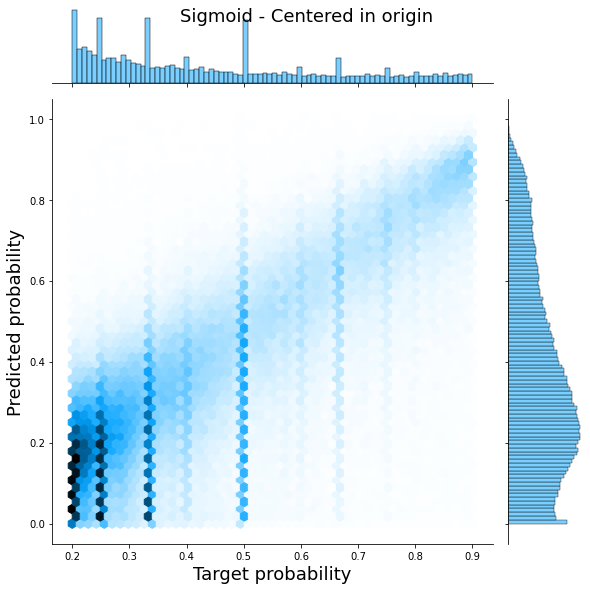

In [25]:
for model_name in r2b_models:
    pred = probabilities[model_name]
    target = targets[model_name]
    jointplot(pred, target, title=model_name)

In [ ]:
model = r2b_models["Gaussian margin initialization"]

In [ ]:
emb = rearrange(model.box_embedding.weight, "... (box d) -> ... box d", box=2)
left = emb[..., 0, :]
right = emb[..., 1, :]
if model.box_embedding.box_constructor is not None:
    boxes = model.box_embedding.box_constructor(left, right)
else:
    boxes = BoxTensor((left, right))

In [ ]:
boxes.left.contiguous().view(-1)

In [ ]:
def plot_box_dist(left, right, xlabel=None, title=None):
    plt.figure(figsize=(10, 6))
    plt.hist(boxes.right.contiguous().view(-1).detach().cpu().numpy(), density=True, color="#4fbfff", bins=100)
    plt.hist(boxes.left.contiguous().view(-1).detach().cpu().numpy(), density=True, color="#8cff92", bins=100)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

In [ ]:
plot_box_dist(boxes.left, boxes.right)